In [1]:
import pandas as pd
# Load the Sentiment140 dataset as a data frame
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
# Print the first 5 rows of the data frame
print(f"\n The shape data is:{df.shape}")


 The shape data is:(1600000, 6)


In [2]:
data = df.copy()
data = data.sample(frac=1)

In [3]:
from pandas.api.types import is_numeric_dtype, is_string_dtype

for col_name in data.columns:
    if is_numeric_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna(0)
    elif is_string_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna('')
data.head()

,polarity,id,date,query,user,text
636810,0,2234022180,Thu Jun 18 22:17:32 PDT 2009,NO_QUERY,wellsie50,"finally got unpacked, only took me four days! ..."
1039126,4,1956771079,Thu May 28 22:38:54 PDT 2009,NO_QUERY,ChicagoAgility,It's funny the things U can learn about friend...
1218385,4,1989825804,Mon Jun 01 02:56:55 PDT 2009,NO_QUERY,ElmoBerry,still laughing at Kristen Stewart dropping her...
630749,0,2232092828,Thu Jun 18 19:26:30 PDT 2009,NO_QUERY,HARAJUKU_MODEL,IM READI TO HAVE FUN BUT I DNT HAVE 1 FRIEND T...
1331649,4,2016037316,Wed Jun 03 06:02:37 PDT 2009,NO_QUERY,AishMeist,"@S_edvard lol that's good, I'm surprisingly co..."


In [4]:
def clean_text(x):
    from gensim.utils import simple_preprocess
    import contractions
    x = contractions.fix(x)
    x = ' '.join(simple_preprocess(x))
    return x

In [5]:
from tqdm import tqdm
tqdm.pandas()
data['clean_text'] = data['text'].progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:37<00:00, 42926.20it/s]


In [6]:
data['polarity'] = data['polarity'].progress_apply((lambda x: 1 if x == 4 else 0))

100%|███████████████████████████████████████████████████████████████████| 1600000/1600000 [00:01<00:00, 1292055.10it/s]


In [7]:
data

,polarity,id,date,query,user,text,clean_text
636810,0,2234022180,Thu Jun 18 22:17:32 PDT 2009,NO_QUERY,wellsie50,"finally got unpacked, only took me four days! ...",finally got unpacked only took me four days tr...
1039126,1,1956771079,Thu May 28 22:38:54 PDT 2009,NO_QUERY,ChicagoAgility,It's funny the things U can learn about friend...,it is funny the things you can learn about fri...
1218385,1,1989825804,Mon Jun 01 02:56:55 PDT 2009,NO_QUERY,ElmoBerry,still laughing at Kristen Stewart dropping her...,still laughing at kristen stewart dropping her...
630749,0,2232092828,Thu Jun 18 19:26:30 PDT 2009,NO_QUERY,HARAJUKU_MODEL,IM READI TO HAVE FUN BUT I DNT HAVE 1 FRIEND T...,am readi to have fun but dnt have friend that ...
1331649,1,2016037316,Wed Jun 03 06:02:37 PDT 2009,NO_QUERY,AishMeist,"@S_edvard lol that's good, I'm surprisingly co...",s_edvard lol that is good am surprisingly conf...
...,...,...,...,...,...,...,...
279793,0,1991884257,Mon Jun 01 07:50:00 PDT 2009,NO_QUERY,ijamshidi,"George, George, George of the jungle... Watch ...",george george george of the jungle watch out f...
180511,0,1966571545,Fri May 29 18:00:41 PDT 2009,NO_QUERY,Beazacamille,phone is dead mega gay,phone is dead mega gay
1474565,1,2065750969,Sun Jun 07 09:13:05 PDT 2009,NO_QUERY,slugyO,My girlfriend is the most amazing person I've ...,my girlfriend is the most amazing person have ...
1169313,1,1980244234,Sun May 31 06:09:44 PDT 2009,NO_QUERY,ms_magane,lyin gout the back evening out my tan lol,lyin gout the back evening out my tan lol


In [8]:
%matplotlib inline
import gensim
import logging
import numpy as np, matplotlib.pyplot as plt, os
import pandas as pd
import json, zipfile
# configure logger. Can be logging.Info or logging.Error to control printouts during training
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR) 
root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data/twitter_airline_sentiment')
data_folder

'C:\\Users\\Leon\\Machine Learning\\Data science for finance\\local_data\\twitter_airline_sentiment'

In [9]:
def load_stopwords(data_folder):
    stopwords_file_name = os.path.join(data_folder, 'stopwords.txt')
    stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"

    if not os.path.isfile(stopwords_file_name):
        import requests
        stopwords = requests.get(stopwords_url).text.split()
        with open(stopwords_file_name,'w+t', encoding='utf-8') as out_file:
            out_file.write(' '.join(stopwords))
    else: 
        with open(stopwords_file_name,'rt', encoding='utf-8') as in_file:
            stopwords = in_file.readline().split()
    stopwords = set(stopwords)
    return stopwords
stopwords = load_stopwords(data_folder)
print(stopwords)

{'these', 'she', 'same', 'whom', 'itself', 'their', 'during', 'while', 'after', 'having', 'yours', 'this', 'than', 'the', 'his', 'about', 'has', 'we', 'be', 'to', 'have', 'can', 'of', 'only', 'its', 'too', 'if', 'here', 'by', 'for', 'down', 'yourself', 'above', 's', 'between', 'you', 'been', 'a', 'more', 'do', 'some', 'don', 'other', 'ours', 'will', 'myself', 'themselves', 'now', 'had', 'again', 'few', 'and', 'in', 'your', 'through', 'himself', 'just', 'our', 'herself', 'that', 'because', 'against', 'own', 'under', 'so', 'being', 'into', 'yourselves', 'he', 'are', 'should', 'was', 'on', 'out', 't', 'up', 'or', 'each', 'with', 'over', 'hers', 'no', 'off', 'once', 'before', 'does', 'but', 'further', 'where', 'me', 'at', 'until', 'ourselves', 'both', 'there', 'very', 'not', 'when', 'most', 'i', 'nor', 'below', 'such', 'what', 'who', 'him', 'my', 'any', 'those', 'am', 'as', 'it', 'from', 'did', 'how', 'then', 'them', 'why', 'which', 'doing', 'they', 'theirs', 'were', 'her', 'all', 'an', 'i

In [10]:
def tokenize(x, stopwords):
    from gensim.utils import simple_preprocess
    return [ token for token in simple_preprocess(x['clean_text']) if token not in stopwords]
data['tokens'] = data.progress_apply(tokenize, stopwords=stopwords, axis=1)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:38<00:00, 41765.79it/s]


In [11]:
import numpy as np

In [12]:
train_test_mask = np.random.random((len(data),))<0.8
train_data = data[train_test_mask].copy()
test_data = data[~train_test_mask].copy()
print(f"Train<->test data: {len(train_data)} <-> {len(test_data)}")

Train<->test data: 1280473 <-> 319527


In [13]:
import gensim
import gensim.downloader
glove_vectors_model = gensim.downloader.load('glove-twitter-200')

[=-------------------------------------------------] 3.9% 29.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 52.8% 400.2/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 758.5/758.5MB downloaded


In [14]:
def get_phrase_vectors(tokens, model):
    import numpy as np
    if len(tokens)>0:
        token_vectors = [model[token] for token in tokens if token in model]
        if len(token_vectors)>0:
            return np.mean(token_vectors,0)        
    return None

def generate_glove_vectors(tokens_column, model):
    import numpy as np
    glove_vectors = tokens_column.apply(get_phrase_vectors, model=model)
    # replace empty glove vectors with random non-empty vectors
    glove_vectors[glove_vectors.isna()] = np.random.choice(glove_vectors[~glove_vectors.isna()],glove_vectors.isna().sum())
    return np.stack(glove_vectors)

In [15]:
from sklearn.linear_model import LogisticRegression

train_glove_vectors = generate_glove_vectors(train_data['tokens'], model=glove_vectors_model)
glove_logit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
glove_logit_model.fit(X=train_glove_vectors,y=train_data['polarity'].values)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [16]:
test_glove_vectors = generate_glove_vectors(test_data['tokens'], model=glove_vectors_model)
test_glove_logit_sentiment = glove_logit_model.predict(test_glove_vectors)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(test_data['polarity'], test_glove_logit_sentiment))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74    159994
           1       0.74      0.76      0.75    159533

    accuracy                           0.74    319527
   macro avg       0.74      0.74      0.74    319527
weighted avg       0.74      0.74      0.74    319527



In [18]:
from sklearn import metrics
from tqdm import tqdm

y_true = test_data['polarity']

# Get the predicted labels
y_pred = test_glove_logit_sentiment
# Calculate the accuracy
# accuracy = metrics.accuracy_score(y_true, y_pred)
# Calculate the precision
precision = metrics.precision_score(y_true, y_pred,pos_label=1)
# Calculate the recall
recall = metrics.recall_score(y_true, y_pred,pos_label=1)
# Calculate the F1 score
f1 = metrics.f1_score(y_true, y_pred,pos_label=1)
auc=metrics.roc_auc_score(y_true, y_pred)
cm = metrics.confusion_matrix(y_true,y_pred)

# Print the results
# print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print('AUC score:', auc)
print('Confusion Matrix', cm)

Precision: 0.738676726355241
Recall: 0.7560818137940113
F1 score: 0.7472779369627508
AUC score: 0.7446859060844752
Confusion Matrix [[117322  42672]
 [ 38913 120620]]


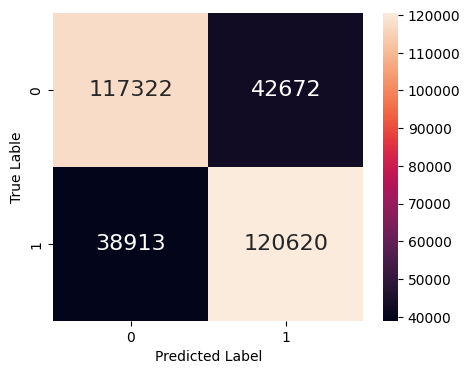

In [19]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(5,4))
# cm_df = pd.DataFrame(cm, index = ['Negative','Positive'], columns = ['Negative','Positive'])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={'size':16})
plt.xlabel("Predicted Label"); plt.ylabel('True Lable');

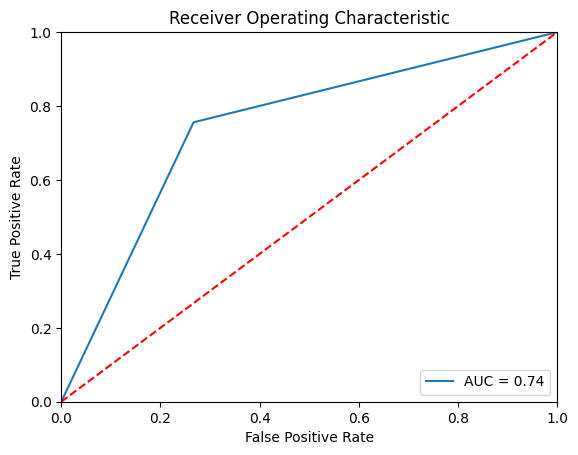

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
from sklearn import svm
train_glove_vectors = generate_glove_vectors(train_data['tokens'], model=glove_vectors_model)
glove_svm_model = svm.SVC(kernel='rbf', degree=3, probability=True)
glove_svm_model.fit(X=train_glove_vectors,y=train_data['polarity'].values)